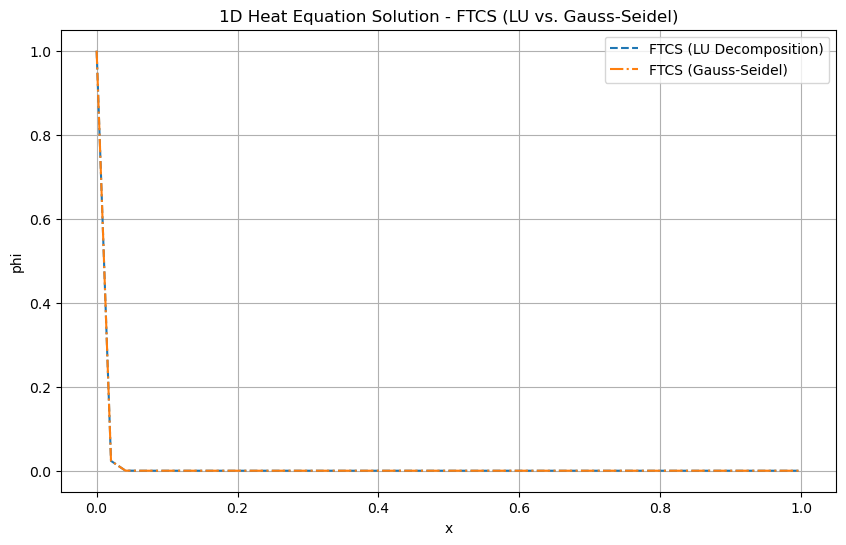

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import splu

# Define parameters
L = 1.0          # Length of the domain
T = 0.00001          # Total simulation time
Nx = 50         # Number of spatial grid points
Nt = 1000        # Number of time steps
alpha = 1.0      # Thermal diffusivity
dx = L / (Nx - 1)  # Spatial step size
dt = T / Nt        # Time step size
r = alpha * dt / dx**2  # Stability parameter

# Check stability condition for FTCS
if r > 0.5:
    raise ValueError("FTCS is unstable for r > 0.5. Adjust dx or dt.")

# Grid points
x = np.linspace(0, L, Nx)

# Initial and boundary conditions
u_initial = np.zeros(Nx)  # Initial condition
u_initial[0] = 1          # Boundary condition at x=0
u_initial[-1] = 0         # Boundary condition at x=L

# Construct the sparse matrix for LU decomposition
diagonal = -2 * np.ones(Nx)
off_diagonal = np.ones(Nx - 1)
A = diags([off_diagonal, diagonal, off_diagonal], offsets=[-1, 0, 1], shape=(Nx, Nx)).tocsc()
lu = splu(A)  # LU decomposition

# FTCS with LU decomposition
def solve_ftcs_lu():
    u = u_initial.copy()
    for n in range(1, Nt):
        # FTCS explicit update
        u_new = u + r * (np.roll(u, -1) - 2*u + np.roll(u, 1))
        # Apply boundary conditions
        u_new[0] = 1
        u_new[-1] = 0
        u = u_new
    return u

# FTCS with Gauss-Seidel iteration
def gauss_seidel_ftcs(u_old, r, tol=1e-12, max_iter=1000):
    u_new = u_old.copy()
    for it in range(max_iter):
        u_prev = u_new.copy()
        for i in range(1, Nx-1):  # Update interior points
            u_new[i] = u_old[i] + r * (u_new[i+1] - 2*u_new[i] + u_new[i-1])
        # Check for convergence
        if np.linalg.norm(u_new - u_prev, ord=np.inf) < tol:
            return u_new
    raise ValueError("Gauss-Seidel did not converge within max_iter iterations")

# FTCS method with Gauss-Seidel
def solve_ftcs_gauss_seidel():
    u = u_initial.copy()
    for n in range(1, Nt):
        u = gauss_seidel_ftcs(u, r)  # Iteratively solve each time step
        u[0] = 1   # Enforce boundary conditions
        u[-1] = 0
    return u

# Solve using both methods
u_ftcs_lu = solve_ftcs_lu()
u_ftcs_gauss = solve_ftcs_gauss_seidel()

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x, u_ftcs_lu, label='FTCS (LU Decomposition)', linestyle='--')
plt.plot(x, u_ftcs_gauss, label='FTCS (Gauss-Seidel)', linestyle='-.')
plt.xlabel('x')
plt.ylabel('phi')
plt.title('1D Heat Equation Solution - FTCS (LU vs. Gauss-Seidel)')
plt.legend()
plt.grid()
plt.show()
